### Import libraries

In [5]:
# import statements
%load_ext autoreload
%load_ext jupyternotify
%autoreload 2
%cd "../../"

import torch 
from torch.autograd import Variable 
import torch.nn as nn
import torch.optim as optim

import warnings
warnings.filterwarnings('ignore')
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    

import numpy as np
import time

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import pickle
from scipy.cluster.vq import kmeans2
import scipy.stats as ss
from scipy.io import loadmat

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify
/m/home/home5/56/kapoorj1/unix/repos/bayesian-ode


### Generate data

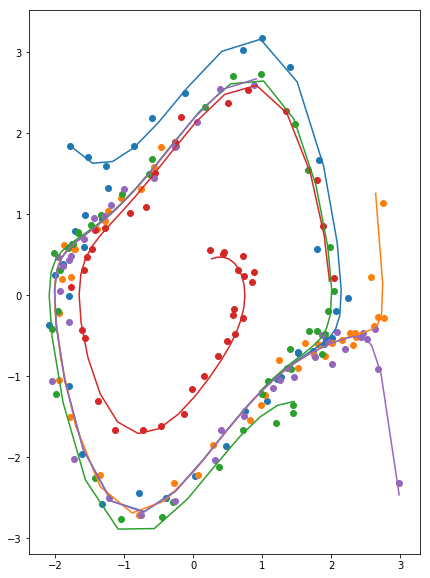

In [23]:
# generate data
use_gpu = 1

class VDP(torch.nn.Module):
    def forward(self, t, x):
        return torch.cat([x[:,1:2], 1*(1-x[:,0:1]**2)*x[:,1:2]-x[:,0:1]],1)

class FHN(torch.nn.Module):
    def forward(self, t, x):
        return torch.cat([3*(x[:,0:1]-x[:,0:1]**3/3.+x[:,1:2]), (0.2-3*x[:,0:1]-0.2*x[:,1:2])/3.], 1)

class LV(torch.nn.Module):
    def forward(self, t, x):
        return torch.cat([1.5*x[:,0:1]-x[:,0:1]*x[:,1:2], -3*x[:,1:2]+x[:,0:1]*x[:,1:2]], 1)
    
from torchdiffeq import odeint_adjoint as odeint
# from torchdiffeq import odeint

device = torch.device('cuda:' + str(use_gpu) if torch.cuda.is_available() else 'cpu')

N = 5
R = 3

x0 = torch.from_numpy(2*R*ss.uniform.rvs(size=[N,2])-R)
# x0 = torch.from_numpy(R*ss.uniform.rvs(size=[N,2])+ R) # for LV model
t = torch.linspace(0., 7., 40)
# t = torch.linspace(0., 21., 120)

with torch.no_grad():
    X = odeint(VDP(), x0, t, method='rk4').numpy()
#     X = odeint(FHN(), x0, t, method='rk4').numpy()
#     X = odeint(LV(), x0, t, method='rk4').numpy()
    X = np.transpose(X,[1,0,2])
    Y = X + ss.norm.rvs(size=X.shape)*0.1

    
plt.figure(1,[7,10])
for i in range(X.shape[0]):
    plt.plot(X[i,:,0],X[i,:,1],'-')
    plt.scatter(Y[i,:,0],Y[i,:,1])

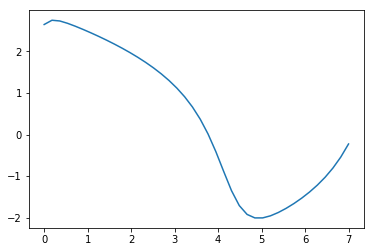

In [24]:
plt.plot(t.numpy(), X[1,:,0])

## Implementation-1, gradients computed via sensitivities (uses autograd as a subroutine) 

In [ ]:
data = {'N': N, 'R': R, 'noise': 0.1, 'x0': x0, 't': t, 'X': X, 'Y': Y}
import os
print(os.getcwd())
pickle.dump(data, open('/m/home/home5/56/kapoorj1/unix/repos/bayesian-ode/lv.pickle', 'wb'))


### Initialize the model, parameters, variables, etc

In [ ]:
# create variables, functions etc
M   = 6 # MxM inducing grid
D   = 2
sf  = 1
ell = 0.75

torch.set_default_tensor_type(torch.DoubleTensor)
xv = np.linspace(np.min([np.min(Y_[:,0]) for Y_ in Y]), np.max([np.max(Y_[:,0]) for Y_ in Y]), M)
yv = np.linspace(np.min([np.min(Y_[:,1]) for Y_ in Y]), np.max([np.max(Y_[:,1]) for Y_ in Y]), M)
xv,yv = np.meshgrid(xv,yv)
Z  = np.array([xv.T.flatten(),yv.T.flatten()]).T
Zt = torch.from_numpy(Z)
Yt = torch.from_numpy(Y)
U0 = 0.1*torch.randn(M*M, D)
# U0 = VDP().forward(0,Zt)

def _flatten(sequence):
    flat = [p.contiguous().view(-1) for p in sequence]
    return torch.cat(flat) if len(flat) > 0 else torch.tensor([])

def sq_dist(X1,X2):
    X1 = X1 / ell
    X1s = torch.sum(X1**2, dim=1).view([-1,1]) 
    X2 = X2 / ell
    X2s = torch.sum(X2**2, dim=1).view([1,-1])
    return -2*torch.mm(X1,torch.t(X2)) + X1s + X2s

def K(X1,X2):
    dist = sq_dist(X1,X2)
    return sf**2 * torch.exp(-dist / 2)

# gradient matching
F_ = (Yt[:,1:,:]-Yt[:,:-1,:]) / (t[1]-t[0])
F_ = F_.contiguous().view(-1,D)
Z_ = Yt[:,:-1,:].contiguous().view(-1,D)
Kxz = K(Zt,Z_)
Kzzinv = (K(Z_,Z_)+0.2*torch.eye(Z_.shape[0])).inverse()
U0 = torch.mm(torch.mm(Kxz,Kzzinv),F_) # not whitened
Linv = torch.cholesky(K(Zt,Zt)).inverse()
U0 = torch.mm(Linv,U0) # whitened

class KernelRegression(torch.nn.Module):
    def __init__(self):
        super(KernelRegression, self).__init__()
        self.U = torch.nn.Parameter(U0, requires_grad=True)
        self.Z = Zt
        self.Kzz = K(Zt,Zt)
        self.Kzzinv = self.Kzz.inverse()
        self.L = torch.cholesky(self.Kzz)
        self.KzzinvL = torch.mm(self.Kzzinv,self.L)

    def forward(self, t, X):
        T = torch.mm(K(X,self.Z),self.KzzinvL)
        return torch.mm(T,self.U)

class ODEINT_FS(torch.autograd.Function):
    @staticmethod
    def forward(ctx, func, x0, t, th):
        xode = odeint(func, x0, t, method='rk4').permute([1,0,2])
        ctx.func = func
        ctx.save_for_backward(x0,t,th,xode)
        return xode # N,T,D
    @staticmethod
    def backward(ctx, *grad_output): # grad_output[0] N,T,D ---> dL/dxode
        # print('backward')
        func = ctx.func
        x0,t,th,xode = ctx.saved_tensors
        N = x0.shape[0]  # problem dimensionality
        D = x0.shape[1]  # problem dimensionality
        MD = torch.numel(th) # number of parameters in the differential function
        with torch.no_grad():
            def ode_sens_rhs(t,xS): # xS = N,D,(1+MD)
                x = xS[:,:,0].view(-1,D) # N,D
                S = xS[:,:,1:] # N,D,MD
                th = list(func.parameters())[0]
                dxs = []
                dSs = []
                for j in range(N):
                    x_ = x[j:j+1].requires_grad_(True) #.detach() # 1,D
                    S_ = S[j] # D,MD
                    J = [] # accumulate columns of J here
                    R = [] # accumulate columns of R here
                    for i in range(D): # partial derivative of output dimension i 
                        with torch.set_grad_enabled(True):
                            f = func(t,x_)[0,i]
                            dfdxth = torch.autograd.grad(f, [x_,th], allow_unused=False, retain_graph=False)
                            J.append(dfdxth[0])
                            R.append(dfdxth[1].view(1,-1)) # 1,MD
                    J = torch.cat(J) # D,D
                    R = torch.cat(R) # D,MD
                    dS = torch.matmul(J,S_)+R # D,MD
                    dx = func(t,x_) # 1,D
                    dxs.append(dx.unsqueeze(2)) # 1,D,1
                    dSs.append(dS.unsqueeze(0)) # 1,D,MD
                dx = torch.cat(dxs) # N,D,1
                dS = torch.cat(dSs) # N,D,MD
                dxdS = torch.cat([dx,dS],2)
                return dxdS
            x0 = torch.unsqueeze(x0,2) # N,D,1
            S0 = torch.zeros(N,D,MD)
            xS0 = torch.cat((x0,S0),2) # N,D,(1+MD)
            xS = odeint(ode_sens_rhs, xS0, t, method='rk4') # T,N,D,(1+MD)
            xode2 = xS[:,:,:,0].permute([1,0,2]) # N,T,D
            # print('error between two ode integrations is {:f}'.format(torch.abs(xode-xode2).sum().numpy()))
            S = xS[:,:,:,1:].permute([1,2,0,3]) # N,D,T,MD
            # print(grad_output[0].shape) # N,T,D
            dlossdx = grad_output[0].permute([0,2,1]).unsqueeze(3) # N,D,T,1
            dlossdU = torch.sum(S*dlossdx,[0,1,2]) # MD
        return None,None,None,dlossdU # N,T,D
    
odeint_fs = ODEINT_FS.apply
kreg = KernelRegression()

# check why doesn't work
# from torch.autograd import gradcheck
# th_ = _flatten(kreg.parameters())
# test = gradcheck(odeint_fs, [kreg,x0,t,th_], eps=1e-6, atol=1e-4)
# print(test)

def odeint_forw_sens(func, x0, t):
    th = _flatten(func.parameters())
    xode = odeint_fs(kreg, x0, t, th)
    return xode
    

### Optimize

In [ ]:
# optimization

logsn = torch.nn.Parameter(torch.zeros(2), requires_grad=True)
params = [kreg.U,logsn]
optimizer = optim.Adam(params, lr=5e-3)

    
for itr in range(500):
    optimizer.zero_grad()
    T   = min(3+itr//10, len(t))
    t_  = t[:T]
    Yt_ = Yt[:,:T,:]
    xode = odeint_forw_sens(kreg,x0,t_)
    loss = torch.sum((Yt_-xode)**2 / torch.exp(logsn)**2) +  torch.numel(Yt_)*torch.sum(logsn)/D + \
        torch.sum(torch.diag(torch.mm(kreg.U.t(),kreg.U)))/2
    loss.backward()
    optimizer.step()

    if itr % 1 == 0:
        with torch.no_grad():
            xode = odeint_forw_sens(kreg,x0,t)
            loss = torch.sum((Yt-xode)**2 / torch.exp(logsn)**2) +  torch.numel(Yt)*torch.sum(logsn)/D
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))

    # break
    end = time.time()


### Visualize

In [ ]:
# plotting
xode = odeint_forw_sens(kreg, x0, t).detach().numpy()
U = kreg.U.detach().numpy()
Z = Zt.detach().numpy()

cols = ['r','b','g','m','c','k']
plt.figure(1,[7,10])
plt.scatter(Z[:,0],Z[:,1],100, facecolors='none', edgecolors='k')
plt.quiver(Z[:,0],Z[:,1],U[:,0],U[:,1],units='height',width=0.006,color='k')
for i in range(min(6,xode.shape[0])):
    plt.plot(Y[i,:,0],Y[i,:,1],'o',color=cols[i])
    plt.plot(xode[i,:,0],xode[i,:,1],'-',color=cols[i])

In [ ]:
for i in range(min(6,xode.shape[0])):
    fig, ax = plt.subplots()
    ax.plot(Y[i,:,0],'o',color=cols[i])
    ax.plot(xode[i,:,0],'-',color=cols[i])

## Implementation-2 that uses Torch autograd, no sensitivities/adjoints 

### Initialize the model, parameters, variables, etc

In [ ]:
# create variables, functions etc
M   = 6 # MxM inducing grid
D   = 2
sf  = 1
ell = 0.75

torch.set_default_tensor_type(torch.DoubleTensor)
xv = np.linspace(np.min([np.min(Y_[:,0]) for Y_ in Y]), np.max([np.max(Y_[:,0]) for Y_ in Y]), M)
yv = np.linspace(np.min([np.min(Y_[:,1]) for Y_ in Y]), np.max([np.max(Y_[:,1]) for Y_ in Y]), M)
xv,yv = np.meshgrid(xv,yv)
Z  = np.array([xv.T.flatten(),yv.T.flatten()]).T
Zt = torch.from_numpy(Z)
Xt = torch.from_numpy(X)
U0 = 0.1*torch.randn(M*M, D)
# U0 = VDP().forward(0,Zt)

def sq_dist(X1,X2):
    X1 = X1 / ell
    X1s = torch.sum(X1**2, dim=1).view([-1,1]) 
    X2 = X2 / ell
    X2s = torch.sum(X2**2, dim=1).view([1,-1])
    return -2*torch.mm(X1,torch.t(X2)) + X1s + X2s

def K(X1,X2):
    dist = sq_dist(X1,X2)
    return sf**2 * torch.exp(-dist / 2)

# gradient matching
F_ = (Xt[:,1:,:]-Xt[:,:-1,:]) / (t[1]-t[0])
F_ = F_.contiguous().view(-1,D)
Z_ = Xt[:,:-1,:].contiguous().view(-1,D)
Kxz = K(Zt,Z_)
Kzzinv = (K(Z_,Z_)+0.2*torch.eye(Z_.shape[0])).inverse()
U0 = torch.mm(torch.mm(Kxz,Kzzinv),F_)


class KernelRegression(torch.nn.Module):
    def __init__(self):
        super(KernelRegression, self).__init__()
        self.U = torch.nn.Parameter(U0, requires_grad=True)
        self.logsn = torch.nn.Parameter(torch.zeros(2), requires_grad=True)
        self.Z = Zt

    def forward(self, t, X):
#         Z = self.Z
#         M = Z.shape[0]
#         N = X.shape[0]
#         A_LU = torch.lu(K(Z,Z).view(-1,M,M)) # 1,M,M
#         Kxz  = torch.t(K(X,Z)).view(-1,M,N)  # 1,M,N
#         A = torch.lu_solve(Kxz, *A_LU).view(M,N) # M x N
#         f = torch.mm(torch.t(A),self.U) # N x M
#         return f
#         Z = self.Z
#         Ltinv = torch.t(torch.cholesky(K(Z,Z))).inverse()
#         return torch.mm(torch.mm(K(X,Z),Ltinv),self.U)
        Z = self.Z
        Kzzinv = K(Z,Z).inverse()
        return torch.mm(torch.mm(K(X,Z),Kzzinv),self.U)
    

Kzzinv = K(Zt, Zt).inverse()

npode = KernelRegression()
# lbfgs = optim.LBFGS(npode.parameters(), lr=1e-3)
optimizer = optim.Adam(npode.parameters(), lr=5e-3)
# optimizer = optim.SGD(npode.parameters(), lr=3e-5)


### Optimize

In [ ]:
# optimization
def closure():
    optimizer.zero_grad()
    xode = odeint(npode, x0, t).permute([1,0,2])
    loss = torch.mean((Xt-xode)**2 / torch.exp(npode.logsn))
    loss.backward()
    return loss

    
# n_iters = 1000
n_iters = 1000

## learning rate scheduling for sgd+momentum and rmsprop
lr = 5e-4
lr_decay=0.03

## Momentum schedulin for sgd+momentum
mom_init = 0.5
mom_final = 0.99
mom_decay = 0.03

for itr in range(n_iters):
    optimizer.zero_grad()

#     for g in optimizer.param_groups:
#         g['lr'] = lr/(1+lr_decay*i)
#     for g in optimizer.param_groups:
#         g['momentum'] = mom_final - (mom_final-mom_init)/(1+mom_decay*i)

    xode = odeint(npode, x0, t, method='rk4').permute([1,0,2])
    loss = torch.sum((Xt-xode)**2 / torch.exp(npode.logsn)**2) +  torch.numel(Xt)*torch.sum(npode.logsn)/D + \
        torch.sum(torch.diag(torch.mm(npode.U.t(), torch.mm(Kzzinv, npode.U))))/2
    loss.backward()
    optimizer.step()
#     lbfgs.step(closure)

    if itr % 1 == 0:
        with torch.no_grad():
            xode = odeint(npode, x0, t, method='rk4').permute([1,0,2])
            if torch.isnan(loss):
                %notify -m "Nan encountered in loss"
                break
            loss = torch.sum((Xt-xode)**2 / torch.exp(npode.logsn))
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))

    end = time.time()

### Visualize

In [ ]:
# plotting
xode = odeint(npode, x0, t).detach().numpy()
U = npode.U.detach().numpy()
Z = npode.Z.detach().numpy()
xode = np.transpose(xode,[1,0,2])

cols = ['r','b','g','m','c','k']
plt.figure(1,[7,10])
plt.scatter(Z[:,0],Z[:,1],100, facecolors='none', edgecolors='k')
plt.quiver(Z[:,0],Z[:,1],U[:,0],U[:,1],units='height',width=0.006,color='k')
for i in range(min(6,xode.shape[0])):
    plt.plot(Y[i,:,0],Y[i,:,1],'o',color=cols[i])
    plt.plot(xode[i,:,0],xode[i,:,1],'-',color=cols[i])

In [ ]:
torch.exp(npode.logsn)

## Inference using MCMC

In [25]:

# create variables, functions etc
M   = 5 # MxM inducing grid
D   = 2
sf  = 1
ell = 0.75
# ell = 1

torch.set_default_tensor_type(torch.DoubleTensor)
xv = np.linspace(np.min([np.min(Y_[:,0]) for Y_ in Y]), np.max([np.max(Y_[:,0]) for Y_ in Y]), M)
yv = np.linspace(np.min([np.min(Y_[:,1]) for Y_ in Y]), np.max([np.max(Y_[:,1]) for Y_ in Y]), M)
xv,yv = np.meshgrid(xv,yv)
Z  = np.array([xv.T.flatten(),yv.T.flatten()]).T
Zt = torch.from_numpy(Z)
Xt = torch.from_numpy(X)
Yt = torch.from_numpy(Y)
U0 = 0.1*torch.randn(M*M, D)
# U0 = VDP().forward(0,Zt)

def sq_dist(X1,X2):
    X1 = X1 / ell
    X1s = torch.sum(X1**2, dim=1).view([-1,1]) 
    X2 = X2 / ell
    X2s = torch.sum(X2**2, dim=1).view([1,-1])
    return -2*torch.mm(X1,torch.t(X2)) + X1s + X2s

def K(X1,X2):
    dist = sq_dist(X1,X2)
    return sf**2 * torch.exp(-dist / 2)

# gradient matching
F_ = (Yt[:,1:,:]-Yt[:,:-1,:]) / (t[1]-t[0])
F_ = F_.contiguous().view(-1,D)
Z_ = Yt[:,:-1,:].contiguous().view(-1,D)
Kxz = K(Zt,Z_)
Kzzinv = (K(Z_,Z_)+0.2*torch.eye(Z_.shape[0])).inverse()
U0 = torch.mm(torch.mm(Kxz,Kzzinv),F_)


class KernelRegression(torch.nn.Module):
    def __init__(self):
        super(KernelRegression, self).__init__()
        self.U = torch.nn.Parameter(U0, requires_grad=True)
        self.logsn = torch.nn.Parameter(torch.zeros(2)+np.log(0.05), requires_grad=True)
        self.Z = Zt

    def forward(self, t, X):
#         Z = self.Z
#         M = Z.shape[0]
#         N = X.shape[0]
#         A_LU = torch.lu(K(Z,Z).view(-1,M,M)) # 1,M,M
#         Kxz  = torch.t(K(X,Z)).view(-1,M,N)  # 1,M,N
#         A = torch.lu_solve(Kxz, *A_LU).view(M,N) # M x N
#         f = torch.mm(torch.t(A),self.U) # N x M
#         return f|
#         Z = self.Z
#         Ltinv = torch.t(torch.cholesky(K(Z,Z))).inverse()
#         return torch.mm(torch.mm(K(X,Z),Ltinv),self.U)
        Z = self.Z
        Kzzinv = K(Z,Z).inverse()
        return torch.mm(torch.mm(K(X,Z),Kzzinv),self.U)

kreg = KernelRegression()
Kzzinv = K(Zt, Zt).inverse()
# lbfgs = optim.LBFGS(npode.parameters(), lr=5e-3)
# optimizer = optim.Adam(npode.parameters(), lr=5e-3)

### Inference

itr = 0


def closure(add_prior=True):
    global itr
#     T   = min(3+itr//10, len(t))
    T   = len(t)
    itr += 1
    t_  = t[:T]
    Yt_ = Yt[:,:T,:]
    xode = odeint(kreg, x0, t_, method='rk4').permute([1,0,2])
    loss = None  
    if add_prior:
        loss = torch.sum((Yt_-xode)**2/(2*torch.exp(kreg.logsn)**2))
        loss += torch.numel(Yt_)*torch.sum(kreg.logsn)/D
        loss += torch.sum(torch.diag(torch.mm(kreg.U.t(),torch.mm(Kzzinv, kreg.U))))/2
    else:
        loss = torch.sum((Yt_-xode)**2)
    return loss

def psgld_closure(add_prior=True):
    global itr
#     T   = min(3+itr//10, len(t))
    T   = len(t)
    itr += 1
    t_  = t[:T]
    Yt_ = Yt[:,:T,:]
    xode = odeint(kreg, x0, t_, method='rk4').permute([1,0,2])
    loss = None  
    if add_prior:
        loss = torch.sum((Yt_-xode)**2/(2*torch.exp(kreg.logsn)**2))
        loss += torch.numel(Yt_)*torch.sum(kreg.logsn)/D
        loss += torch.sum(torch.diag(torch.mm(kreg.U.t(),torch.mm(Kzzinv, kreg.U))))/2
    else:
        loss = torch.sum((Yt_-xode)**2)
    return loss/N


# logsn = torch.nn.Parameter(torch.zeros(2), requires_grad=True)
# logsn = torch.log(torch.Tensor([0.1]))
# params = kreg.parameters()
params = [kreg.U, kreg.logsn]

from samplers.langevin import MALA, MMALA, pSGLD, HAMCMC, HAMCMC2, HAMCMC3, HAMCMC4
from samplers.hamiltonian import aSGHMC

# sampler = MMALA(params, metric_obj=metric, lr=1e-4)
# sampler = MALA(params, lr=1e-4, add_noise=True)
# sampler = SGLD(params, lr0=0.0001, gamma=0.55, t0=100, alpha=0.1)


# chain, logp_array = sampler.sample(closure, burn_in=2000, num_samples=1000, print_loss=True)

# sampler = pSGLD(params, lr0=3e-2, lr_gamma=0.55, lr_t0=100, lr_alpha=0.3, lambda_=1e-8, alpha=0.99)
# chain, logp_array = sampler.sample(psgld_closure, burn_in=600, num_samples=1000, print_loss=True)

# sampler = HAMCMC(params, lr0=1e-4, lr_gamma=0.55, lr_t0=100, lr_alpha=0.3, trust_reg=1e0, memory=3, H_gamma=1e-5, cholesky_factor=1e-3)
# chain, logp_array = sampler.sample(closure, burn_in=500, num_samples=100, print_loss=True, use_metric=True)

# sampler = HAMCMC2(params, lr0=1e-4, lr_gamma=0.55, lr_t0=100, lr_alpha=0.3, trust_reg=1e0, memory=3, H_gamma=1e-3, cholesky_factor=1e-3)
# chain, logp_array = sampler.sample(closure, burn_in=500, num_samples=100, print_loss=True, use_old_lbfgs=True, add_noise=False)

# sampler = HAMCMC3(params, lr0=1e-4, lr_gamma=0.55, lr_t0=100, lr_alpha=0.3, trust_reg=1e0, memory=3, H_gamma=1e-3, cholesky_factor=1e-3)
# chain, logp_array = sampler.sample(closure, burn_in=500, num_samples=100, print_loss=True, use_old_lbfgs=True, add_noise=False)

itr = 0
lr=1e-2
def lr_scheduler():
    global itr
    itr += 1
#     if itr >500:
#         return lr/np.sqrt((1+0.1*itr))
    return lr

sampler = aSGHMC(params, lr=lr, add_noise=True)
chain = sampler.sample(closure, burn_in=600, num_samples=1000, print_loss=True, lr_scheduler=lr_scheduler)


<class 'dict'>
Burn-in phase started
Burn-in iter 0001 | loss 217.113203
Burn-in iter 0002 | loss 216.128147
Burn-in iter 0003 | loss 214.769287
Burn-in iter 0004 | loss 213.074118
Burn-in iter 0005 | loss 211.071818
Burn-in iter 0006 | loss 208.790176
Burn-in iter 0007 | loss 206.250896
Burn-in iter 0008 | loss 203.475435
Burn-in iter 0009 | loss 200.484183
Burn-in iter 0010 | loss 197.296412
Burn-in iter 0011 | loss 193.931589
Burn-in iter 0012 | loss 190.406301
Burn-in iter 0013 | loss 186.738023
Burn-in iter 0014 | loss 182.941648
Burn-in iter 0015 | loss 179.037115
Burn-in iter 0016 | loss 175.039449
Burn-in iter 0017 | loss 170.962765
Burn-in iter 0018 | loss 166.823293
Burn-in iter 0019 | loss 162.634266
Burn-in iter 0020 | loss 158.410990
Burn-in iter 0021 | loss 154.167506
Burn-in iter 0022 | loss 149.915978
Burn-in iter 0023 | loss 145.671293
Burn-in iter 0024 | loss 141.445188
Burn-in iter 0025 | loss 137.248636
Burn-in iter 0026 | loss 133.093221
Burn-in iter 0027 | loss 12

Burn-in iter 0234 | loss 14.912480
Burn-in iter 0235 | loss 14.815637
Burn-in iter 0236 | loss 14.721448
Burn-in iter 0237 | loss 14.628519
Burn-in iter 0238 | loss 14.537507
Burn-in iter 0239 | loss 14.447904
Burn-in iter 0240 | loss 14.358004
Burn-in iter 0241 | loss 14.265503
Burn-in iter 0242 | loss 14.176603
Burn-in iter 0243 | loss 14.093148
Burn-in iter 0244 | loss 14.007545
Burn-in iter 0245 | loss 13.922469
Burn-in iter 0246 | loss 13.844462
Burn-in iter 0247 | loss 13.768647
Burn-in iter 0248 | loss 13.691872
Burn-in iter 0249 | loss 13.617191
Burn-in iter 0250 | loss 13.544334
Burn-in iter 0251 | loss 13.473215
Burn-in iter 0252 | loss 13.400499
Burn-in iter 0253 | loss 13.324902
Burn-in iter 0254 | loss 13.250264
Burn-in iter 0255 | loss 13.172591
Burn-in iter 0256 | loss 13.097878
Burn-in iter 0257 | loss 13.029609
Burn-in iter 0258 | loss 12.955121
Burn-in iter 0259 | loss 12.884651
Burn-in iter 0260 | loss 12.821037
Burn-in iter 0261 | loss 12.753360
Burn-in iter 0262 | 

Burn-in iter 0473 | loss 7.756200
Burn-in iter 0474 | loss 7.753263
Burn-in iter 0475 | loss 7.738416
Burn-in iter 0476 | loss 7.713844
Burn-in iter 0477 | loss 7.684326
Burn-in iter 0478 | loss 7.664404
Burn-in iter 0479 | loss 7.655184
Burn-in iter 0480 | loss 7.653233
Burn-in iter 0481 | loss 7.666686
Burn-in iter 0482 | loss 7.661544
Burn-in iter 0483 | loss 7.650162
Burn-in iter 0484 | loss 7.644073
Burn-in iter 0485 | loss 7.646265
Burn-in iter 0486 | loss 7.643692
Burn-in iter 0487 | loss 7.642449
Burn-in iter 0488 | loss 7.642971
Burn-in iter 0489 | loss 7.643491
Burn-in iter 0490 | loss 7.642864
Burn-in iter 0491 | loss 7.645383
Burn-in iter 0492 | loss 7.640824
Burn-in iter 0493 | loss 7.634111
Burn-in iter 0494 | loss 7.623995
Burn-in iter 0495 | loss 7.614428
Burn-in iter 0496 | loss 7.607744
Burn-in iter 0497 | loss 7.606117
Burn-in iter 0498 | loss 7.602364
Burn-in iter 0499 | loss 7.592317
Burn-in iter 0500 | loss 7.575412
Burn-in iter 0501 | loss 7.555135
Burn-in iter 0

Sample iter 0117 | loss 6.540662
Sample iter 0118 | loss 6.531764
Sample iter 0119 | loss 6.556947
Sample iter 0120 | loss 6.566022
Sample iter 0121 | loss 6.557073
Sample iter 0122 | loss 6.539489
Sample iter 0123 | loss 6.542872
Sample iter 0124 | loss 6.556836
Sample iter 0125 | loss 6.574812
Sample iter 0126 | loss 6.559600
Sample iter 0127 | loss 6.509122
Sample iter 0128 | loss 6.470346
Sample iter 0129 | loss 6.443213
Sample iter 0130 | loss 6.436110
Sample iter 0131 | loss 6.449525
Sample iter 0132 | loss 6.471285
Sample iter 0133 | loss 6.488761
Sample iter 0134 | loss 6.493820
Sample iter 0135 | loss 6.484681
Sample iter 0136 | loss 6.474978
Sample iter 0137 | loss 6.481853
Sample iter 0138 | loss 6.508881
Sample iter 0139 | loss 6.533779
Sample iter 0140 | loss 6.513657
Sample iter 0141 | loss 6.454221
Sample iter 0142 | loss 6.404411
Sample iter 0143 | loss 6.373432
Sample iter 0144 | loss 6.358815
Sample iter 0145 | loss 6.337479
Sample iter 0146 | loss 6.314506
Sample ite

Sample iter 0366 | loss 5.972302
Sample iter 0367 | loss 5.967075
Sample iter 0368 | loss 5.962297
Sample iter 0369 | loss 5.951711
Sample iter 0370 | loss 5.946314
Sample iter 0371 | loss 5.948184
Sample iter 0372 | loss 5.955109
Sample iter 0373 | loss 5.957975
Sample iter 0374 | loss 5.955714
Sample iter 0375 | loss 5.954870
Sample iter 0376 | loss 5.956577
Sample iter 0377 | loss 5.963356
Sample iter 0378 | loss 5.965052
Sample iter 0379 | loss 5.967712
Sample iter 0380 | loss 5.965857
Sample iter 0381 | loss 5.972821
Sample iter 0382 | loss 5.994819
Sample iter 0383 | loss 6.015033
Sample iter 0384 | loss 6.026537
Sample iter 0385 | loss 6.031134
Sample iter 0386 | loss 6.033550
Sample iter 0387 | loss 6.037842
Sample iter 0388 | loss 6.041458
Sample iter 0389 | loss 6.051604
Sample iter 0390 | loss 6.060071
Sample iter 0391 | loss 6.044032
Sample iter 0392 | loss 6.020500
Sample iter 0393 | loss 6.014929
Sample iter 0394 | loss 6.016395
Sample iter 0395 | loss 6.017099
Sample ite

Sample iter 0615 | loss 5.611859
Sample iter 0616 | loss 5.619082
Sample iter 0617 | loss 5.621279
Sample iter 0618 | loss 5.633292
Sample iter 0619 | loss 5.651242
Sample iter 0620 | loss 5.659821
Sample iter 0621 | loss 5.653019
Sample iter 0622 | loss 5.648452
Sample iter 0623 | loss 5.642305
Sample iter 0624 | loss 5.645445
Sample iter 0625 | loss 5.657663
Sample iter 0626 | loss 5.665464
Sample iter 0627 | loss 5.665165
Sample iter 0628 | loss 5.670620
Sample iter 0629 | loss 5.690123
Sample iter 0630 | loss 5.687543
Sample iter 0631 | loss 5.690711
Sample iter 0632 | loss 5.689700
Sample iter 0633 | loss 5.698948
Sample iter 0634 | loss 5.690299
Sample iter 0635 | loss 5.681466
Sample iter 0636 | loss 5.671112
Sample iter 0637 | loss 5.671873
Sample iter 0638 | loss 5.682898
Sample iter 0639 | loss 5.705924
Sample iter 0640 | loss 5.737587
Sample iter 0641 | loss 5.784074
Sample iter 0642 | loss 5.805295
Sample iter 0643 | loss 5.806845
Sample iter 0644 | loss 5.781642
Sample ite

Sample iter 0864 | loss 5.917518
Sample iter 0865 | loss 5.866319
Sample iter 0866 | loss 5.801607
Sample iter 0867 | loss 5.760617
Sample iter 0868 | loss 5.772738
Sample iter 0869 | loss 5.778793
Sample iter 0870 | loss 5.779058
Sample iter 0871 | loss 5.757985
Sample iter 0872 | loss 5.775950
Sample iter 0873 | loss 5.824664
Sample iter 0874 | loss 5.832524
Sample iter 0875 | loss 5.806437
Sample iter 0876 | loss 5.765741
Sample iter 0877 | loss 5.767223
Sample iter 0878 | loss 5.830818
Sample iter 0879 | loss 5.895527
Sample iter 0880 | loss 5.880970
Sample iter 0881 | loss 5.831149
Sample iter 0882 | loss 5.802525
Sample iter 0883 | loss 5.813847
Sample iter 0884 | loss 5.800797
Sample iter 0885 | loss 5.774230
Sample iter 0886 | loss 5.713037
Sample iter 0887 | loss 5.689496
Sample iter 0888 | loss 5.710209
Sample iter 0889 | loss 5.728237
Sample iter 0890 | loss 5.719723
Sample iter 0891 | loss 5.702558
Sample iter 0892 | loss 5.710953
Sample iter 0893 | loss 5.752803
Sample ite

ValueError: too many values to unpack (expected 2)

### Visualization

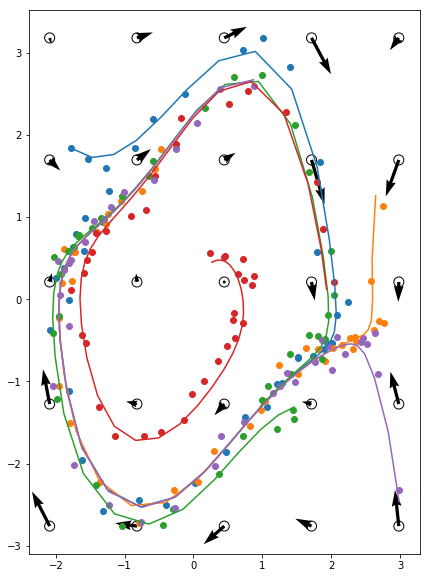

In [26]:
chain = sampler.samples[-200::10]
# plotting
mean_U = np.mean([i[0][0][0] for i in chain if i[1]], axis=0)

kreg.U.data = torch.from_numpy(mean_U)
mean_logsn = np.mean([i[0][0][1] for i in chain if i[1]], axis=0)
kreg.logsn.data = torch.from_numpy(mean_logsn)
xode = odeint(kreg, x0, t).detach().numpy()
# U = kreg.U.detach().numpy()
U = mean_U
Z = kreg.Z.detach().numpy()
xode = np.transpose(xode,[1,0,2])

cols = ['r','b','g','m','c','k']
plt.figure(1,[7,10])
plt.scatter(Z[:,0],Z[:,1],100, facecolors='none', edgecolors='k')
plt.quiver(Z[:,0],Z[:,1],U[:,0],U[:,1],units='height',width=0.006,color='k')
for i in range(min(6,xode.shape[0])):
    color=np.random.rand(3)
    plt.scatter(Y[i,:,0],Y[i,:,1],)
    plt.plot(xode[i,:,0],xode[i,:,1],'-')

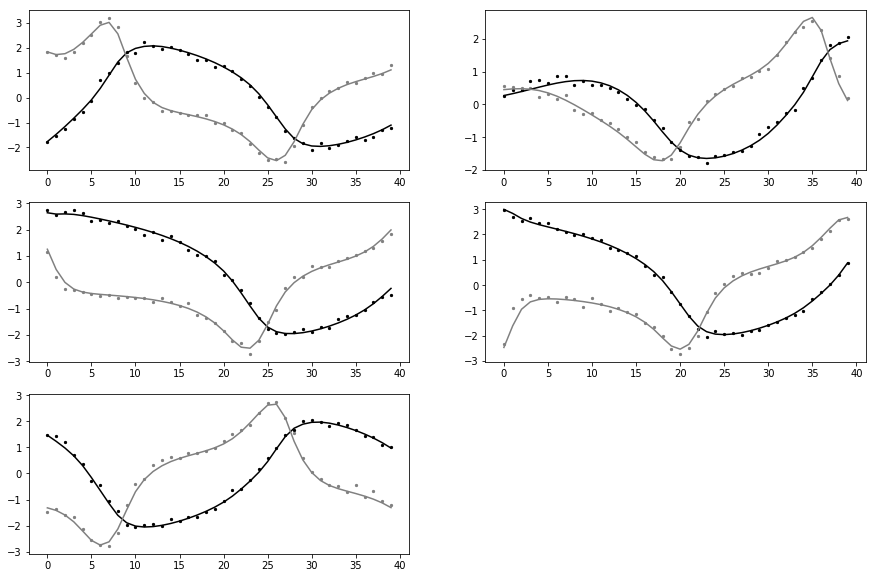

In [27]:
fig, ax = plt.subplots(nrows=(min(6,xode.shape[0])+1)//2, ncols=2, figsize=(15,10))
axes = [ax[i][j] for j in range(2) for i in range(len(ax))]
for i in range(min(6,xode.shape[0])):
    axes[i].scatter(range(len(Y[i,:,0])),Y[i,:,0],color='k',s=5)
    axes[i].plot(xode[i,:,0],'-',color='k')
    axes[i].scatter(range(len(Y[i,:,1])),Y[i,:,1],color='gray',s=5)
    axes[i].plot(xode[i,:,1],'-',color='gray')
for i in range(min(6,xode.shape[0]), len(axes)):
    fig.delaxes(axes[i])

In [28]:
plt.plot(logp_array[400:])

NameError: name 'logp_array' is not defined

In [29]:
R_= 2
x0_ = torch.from_numpy(2*R_*ss.uniform.rvs(size=[10,2])-R_)
t_ = torch.linspace(0., 28., 160)
t_numpy = t_.clone().detach().numpy()

xode_gp = []
for i in range(len(chain)):
    kreg.U.data = torch.from_numpy(chain[i][0][0][0])
    xode_gp.append(odeint(kreg, x0_, t_).detach().numpy())
    xode_gp[-1] = np.transpose(xode_gp[-1],[1,0,2])

xode_gp_mean = np.zeros_like(xode_gp[0])
xode_gp_std = np.zeros_like(xode_gp[0])

for i in range(xode_gp_mean.shape[0]):
    xode_gp_mean[i,:,0] = np.mean([xode_gp[j][i,:,0] for j in range(len(xode_gp))], axis=0)
    xode_gp_mean[i,:,1] = np.mean([xode_gp[j][i,:,1] for j in range(len(xode_gp))], axis=0)
    xode_gp_std[i,:,0] = np.std([xode_gp[j][i,:,0] for j in range(len(xode_gp))], axis=0)
    xode_gp_std[i,:,1] = np.std([xode_gp[j][i,:,1] for j in range(len(xode_gp))], axis=0)
    
    
xode_real = odeint(VDP(), x0_, t_).detach().numpy()
xode_real = np.transpose(xode_real,[1,0,2])

    

(5, 160, 2)
(5, 160, 2)
(10, 160, 2)


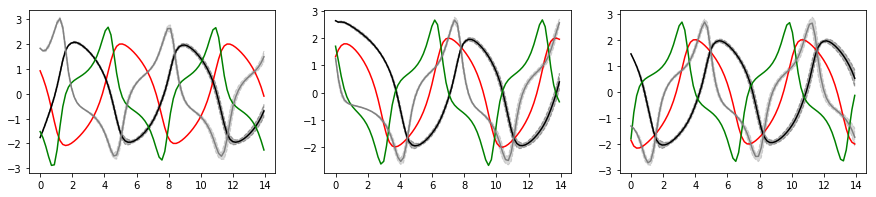

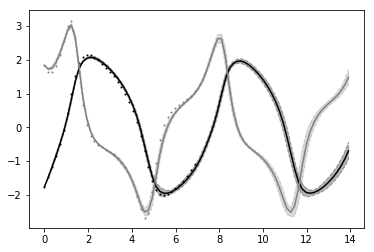

In [37]:
print(xode_gp_mean.shape)
print(xode_gp_std.shape)
print(xode_real.shape)


num_plots = 3
# fig, ax = plt.subplots(nrows=(num_plots+1)//2, ncols=2, figsize=(15,10))
fig, axes = plt.subplots(ncols=num_plots, nrows=1, figsize=(15,3))
# axes = [ax[i][j] for j in range(2) for i in range(len(ax))]
for i in range(num_plots):
    axes[i].plot(t_numpy[:80],xode_real[i,0:80,0],'-',color='r')
    axes[i].fill_between(x=t_numpy[:80],
                         y1=xode_gp_mean[i,0:80,0]-5*xode_gp_std[i,0:80,0],
                         y2=xode_gp_mean[i,0:80,0]+5*xode_gp_std[i,0:80,0],
                         linestyle='--',color='k', alpha=0.3)
    axes[i].plot(t_numpy[:80],
                 xode_gp_mean[i,0:80,0],
                 linestyle='-',color='k')
    axes[i].plot(t_numpy[:80],xode_real[i,0:80,1],'-',color='g')
    axes[i].fill_between(x=t_numpy[:80],
                         y1=xode_gp_mean[i,0:80,1]-5*xode_gp_std[i,0:80,1],
                         y2=xode_gp_mean[i,0:80,1]+5*xode_gp_std[i,0:80,1],
                         linestyle='--',color='gray', alpha=0.3)
    axes[i].plot(t_numpy[:80],
                 xode_gp_mean[i,0:80,1],
                 linestyle='-',color='gray')
for i in range(num_plots, len(axes)):
    fig.delaxes(axes[i])
    
fig, ax = plt.subplots()
ax.scatter(t_numpy[:40], X[0,:,0], color='k', s=1)
ax.scatter(t_numpy[:40], X[0,:,1], color='gray', s=1)


xode_gp = []

for i in range(len(chain)):
    kreg.U.data = torch.from_numpy(chain[i][0][0][0])
    xode_gp.append(odeint(kreg, x0, t_).detach().numpy())
    xode_gp[-1] = np.transpose(xode_gp[-1],[1,0,2])

xode_gp_mean = np.zeros_like(xode_gp[0])
xode_gp_std = np.zeros_like(xode_gp[0])

for i in range(xode_gp_mean.shape[0]):
    xode_gp_mean[i,:,0] = np.mean([xode_gp[j][i,:,0] for j in range(len(xode_gp))], axis=0)
    xode_gp_mean[i,:,1] = np.mean([xode_gp[j][i,:,1] for j in range(len(xode_gp))], axis=0)
    xode_gp_std[i,:,0] = np.std([xode_gp[j][i,:,0] for j in range(len(xode_gp))], axis=0)
    xode_gp_std[i,:,1] = np.std([xode_gp[j][i,:,1] for j in range(len(xode_gp))], axis=0)
    
ax.fill_between(x=t_numpy[:80],
                 y1=xode_gp_mean[0,0:80,0]-5*xode_gp_std[0,0:80,0],
                 y2=xode_gp_mean[0,0:80,0]+5*xode_gp_std[0,0:80,0],
                 linestyle='--',color='k', alpha=0.3)
ax.plot(t_numpy[:80],
         xode_gp_mean[0,0:80,0],
         linestyle='-',color='k')
ax.fill_between(x=t_numpy[:80],
                 y1=xode_gp_mean[0,0:80,1]-5*xode_gp_std[0,0:80,1],
                 y2=xode_gp_mean[0,0:80,1]+5*xode_gp_std[0,0:80,1],
                 linestyle='--',color='gray', alpha=0.3)
ax.plot(t_numpy[:80],
         xode_gp_mean[0,0:80,1],
         linestyle='-',color='gray')


In [ ]:
plt.plot([np.mean(np.exp(i[0][0][1])) for i in sampler.samples[:] if i[1]])
print(sampler.samples[10][0][0][1])
